# Setup

## Install and Import

In [0]:
# Install pytorch and tqdm (if necessary)
!pip install torch
!pip install torchvision
!pip install tqdm

In [0]:
# Mount your google drive as the data drive
# This will require google authorization
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
# Handle imports

import math
import os
import datetime
import csv
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import numpy as np
import tqdm

from IPython import display

## Arguments

In [0]:
# The Args object will contain all of our parameters
# If you want to run with different arguments, create another Args object

class Args(object):
  def __init__(self, name='mnist', batch_size=64, test_batch_size=1000,
            epochs=10, lr=0.01, optimizer='sgd', momentum=0.5,
            seed=1, log_interval=100, dataset='mnist',
            data_dir='/content/drive/My Drive/cs482/data', model='default',
            cuda=True, beta1=0.9, beta2=0.999, eps=1e-08):
    self.name = name # name for this training run. Don't use spaces.
    self.batch_size = batch_size
    self.test_batch_size = test_batch_size # Input batch size for testing
    self.epochs = epochs # Number of epochs to train
    self.lr = lr # Learning rate
    self.optimizer = optimizer # sgd/p1sgd/adam/rms_prop
    self.momentum = momentum # SGD Momentum
    self.seed = seed # Random seed
    self.log_interval = log_interval # Batches to wait before logging
                                     # detailed status. 0 = never
    self.dataset = dataset # mnist/fashion_mnist
    self.data_dir = data_dir
    self.model = model # default/P2Q7DoubleChannelsNet/P2Q7HalfChannelsNet/
                  # P2Q8BatchNormNet/P2Q9DropoutNet/P2Q10DropoutBatchnormNet/
                  # P2Q11ExtraConvNet/P2Q12RemoveLayerNet/P2Q13UltimateNet
    self.cuda = cuda and torch.cuda.is_available()
    
    # for the Adam optimizer
    # Default Adam optimizer params
    # lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False
    self.beta1 = beta1
    self.beta2 = beta2
    self.eps = eps

## Models

### Default

In [0]:
# Define the neural network classes

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        # F is just a functional wrapper for modules from the nn package
        # see http://pytorch.org/docs/_modules/torch/nn/functional.html
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)



### Half Channel Net

In [0]:
class P2Q7HalfChannelsNet(nn.Module):
    def __init__(self):
        super(P2Q7HalfChannelsNet, self).__init__()
        # Half channels
        self.conv1 = nn.Conv2d(1, 5, kernel_size=5)  # Changed output channels to 5
        self.conv2 = nn.Conv2d(5, 20, kernel_size=5)  # Changed input channels to 5
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        # F is just a functional wrapper for modules from the nn package
        # see http://pytorch.org/docs/_modules/torch/nn/functional.html
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

### Double Channel Net

In [0]:
class P2Q7DoubleChannelsNet(nn.Module):
    def __init__(self):
        super(P2Q7DoubleChannelsNet, self).__init__()
        # Double channels
        self.conv1 = nn.Conv2d(1, 20, kernel_size=5)  # Changed output channels to 20
        self.conv2 = nn.Conv2d(20, 20, kernel_size=5)  # Changed input channels to 20
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        # F is just a functional wrapper for modules from the nn package
        # see http://pytorch.org/docs/_modules/torch/nn/functional.html
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)



### Batchnorm Net

In [0]:
class P2Q8BatchNormNet(nn.Module):
    def __init__(self):
        super(P2Q8BatchNormNet, self).__init__()
        #  Batchnorm
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.bn_1 = nn.BatchNorm2d(10)  # define batch norm layer
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        # F is just a functional wrapper for modules from the nn package
        # see http://pytorch.org/docs/_modules/torch/nn/functional.html
        x = F.relu(F.max_pool2d(self.bn_1(self.conv1(x)), 2))  # added the batchnorm after the conv layer
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)



### Dropout Net

In [0]:
class P2Q9DropoutNet(nn.Module):
    def __init__(self):
        super(P2Q9DropoutNet, self).__init__()
        #  Dropout
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.bn_1 = nn.BatchNorm2d(10)  # define batch norm layer
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        # F is just a functional wrapper for modules from the nn package
        # see http://pytorch.org/docs/_modules/torch/nn/functional.html
        
        # added the batchnorm after the conv layer, dropout after batchnorm
        x = F.dropout2d(self.bn_1(self.conv1(x)), training=self.training) 
        x = F.relu(F.max_pool2d(x, 2))  
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)



### Dropout Batchnorm Net

In [0]:
class P2Q10DropoutBatchnormNet(nn.Module):
    def __init__(self):
        super(P2Q10DropoutBatchnormNet, self).__init__()
        #  Dropout Batch norm
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.bn_1 = nn.BatchNorm2d(10)  # define batch norm layer
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        # F is just a functional wrapper for modules from the nn package
        # see http://pytorch.org/docs/_modules/torch/nn/functional.html
        
        # added the dropout after the conv layer, then the batchnorm
        x = F.dropout2d(self.conv1(x), training=self.training) 
        x = F.relu(F.max_pool2d(self.bn_1(x), 2))  
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)



### Extra Conv Net

In [0]:
class P2Q11ExtraConvNet(nn.Module):
    def __init__(self):
        super(P2Q11ExtraConvNet, self).__init__()
        # Extra conv2d
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, padding=2)  # changed padding to output 28*28 image
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5, padding=2)  # changed padding to output 14*14 image
        self.conv3 = nn.Conv2d(20, 64, kernel_size=3, padding=1)  # added this, outputs 7*7 image
        self.fc1 = nn.Linear(7*7*64, 50)  # changed this for the 7*7*64 neurons - no max pool at end
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        # F is just a functional wrapper for modules from the nn package
        # see http://pytorch.org/docs/_modules/torch/nn/functional.html
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 7*7*64)  # changed the flattened output
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)



### Remove Layer Net

In [0]:
class P2Q12RemoveLayerNet(nn.Module):
    def __init__(self):
        super(P2Q12RemoveLayerNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(8*8*20, 50)  # changed this for the 8*8*20 neurons
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        # F is just a functional wrapper for modules from the nn package
        # see http://pytorch.org/docs/_modules/torch/nn/functional.html
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(self.conv2(x), 2)  # removed the max pool layer
        x = x.view(-1, 8*8*20)  # changed flattened output
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)



### Ultimate Net 0

In [0]:
class UltimateNet00(nn.Module):
    def __init__(self):
        super(P2Q13UltimateNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, padding=2)
        self.bn_1 = nn.BatchNorm2d(64)  # define batch norm layer
        self.conv2 = nn.Conv2d(64, 192, kernel_size=5, padding=2)
        self.bn_2 = nn.BatchNorm2d(192)  # define batch norm layer
        self.conv3 = nn.Conv2d(192, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(3136, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        # F is just a functional wrapper for modules from the nn package
        # see http://pytorch.org/docs/_modules/torch/nn/functional.html
        x = F.dropout2d(F.relu(F.max_pool2d(self.bn_1(self.conv1(x)), 2)), p=0.2, training=self.training)
        x = F.dropout2d(F.relu(F.max_pool2d(self.bn_2(self.conv2(x)), 2)), p=0.2, training=self.training)
        x = self.conv3(x)
        x = x.view(-1, 3136)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

### Ultimate Net

In [0]:
class P2Q13UltimateNet(nn.Module):
    def __init__(self):
        super(P2Q13UltimateNet, self).__init__()
        # Ultimate Net
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, padding=2)
        self.bn_1 = nn.BatchNorm2d(64)  # define batch norm layer
        self.conv2 = nn.Conv2d(64, 192, kernel_size=5, padding=2)
        self.bn_2 = nn.BatchNorm2d(192)  # define batch norm layer
        self.conv3 = nn.Conv2d(192, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(3136, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        # F is just a functional wrapper for modules from the nn package
        # see http://pytorch.org/docs/_modules/torch/nn/functional.html
        x = F.dropout2d(F.relu(F.max_pool2d(self.bn_1(self.conv1(x)), 2)), p=0.2, training=self.training)
        x = F.dropout2d(F.relu(F.max_pool2d(self.bn_2(self.conv2(x)), 2)), p=0.2, training=self.training)
        x = self.conv3(x)
        x = x.view(-1, 3136)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

### Ultimate Net 2

In [0]:
class UltimateNet02(nn.Module):
    def __init__(self):
        super(UltimateNet02, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, padding=2)
        self.bn_1 = nn.BatchNorm2d(64)  # define batch norm layer
        self.conv2 = nn.Conv2d(64, 192, kernel_size=5, padding=2)
        self.bn_2 = nn.BatchNorm2d(192)  # define batch norm layer
        self.conv3 = nn.Conv2d(192, 64, kernel_size=3, padding=1)
        self.bn_3 = nn.BatchNorm2d(64)  # define batch norm layer
        self.fc1 = nn.Linear(3136, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        # F is just a functional wrapper for modules from the nn package
        # see http://pytorch.org/docs/_modules/torch/nn/functional.html
        x = F.dropout2d(F.relu(F.max_pool2d(self.bn_1(self.conv1(x)), 2)), p=0.2, training=self.training)
        x = F.dropout2d(F.relu(F.max_pool2d(self.bn_2(self.conv2(x)), 2)), p=0.2, training=self.training)
        x = F.dropout2d(self.bn_3(self.conv3(x)), p=0.2, training=self.training)
        x = x.view(-1, 3136)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

### Ultimate Net 3 - As Close to AlexNet as possible

In [0]:
class UltimateNet03(nn.Module):
    def __init__(self):
        super(UltimateNet03, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, padding=2)
        self.bn_1 = nn.BatchNorm2d(64)  # define batch norm layer
        self.conv2 = nn.Conv2d(64, 192, kernel_size=3, padding=1)
        self.bn_2 = nn.BatchNorm2d(192)  # define batch norm layer
        self.conv3 = nn.Conv2d(192, 384, kernel_size=3, padding=1)
        self.bn_3 = nn.BatchNorm2d(384)  # define batch norm layer
        self.conv4 = nn.Conv2d(384, 256, kernel_size=3, padding=1)
        self.bn_4 = nn.BatchNorm2d(256)  # define batch norm layer
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn_5 = nn.BatchNorm2d(256)  # define batch norm layer
        self.fc1 = nn.Linear(2304, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        # F is just a functional wrapper for modules from the nn package
        # see http://pytorch.org/docs/_modules/torch/nn/functional.html
        x = F.dropout2d(F.relu(F.max_pool2d(self.bn_1(self.conv1(x)), 2)), p=0.2, training=self.training)
        x = F.dropout2d(F.relu(F.max_pool2d(self.bn_2(self.conv2(x)), 2)), p=0.2, training=self.training)
        x = F.relu(self.bn_3(self.conv3(x)))
        x = F.relu(self.bn_4(self.conv4(x)))
        x = F.relu(F.max_pool2d(self.conv5(x), 3, stride=2))
        x = x.view(-1, 2304)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

## Prepare Data

In [0]:
def prepare_dataset(args):
    # choose the dataset
    if args.dataset == 'mnist':
        DatasetClass = datasets.MNIST
    elif args.dataset == 'fashion_mnist':
        DatasetClass = datasets.FashionMNIST
    else:
        raise ValueError('unknown dataset: ' + args.dataset +
                ' try mnist or fashion_mnist')

    def time_stamp(fname, fmt='%m-%d-%H-%M_{fname}'):
        return datetime.datetime.now().strftime(fmt).format(fname=fname)
        
    training_run_name = time_stamp(args.dataset + '_' + args.name)

    kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}

    # Create the dataset: mnist or fasion_mnist
    dataset_dir = os.path.join(args.data_dir, args.dataset)
    training_run_dir = os.path.join(args.data_dir, training_run_name)
    train_dataset = DatasetClass(
        dataset_dir, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ]))
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=args.batch_size, shuffle=True, **kwargs)
    test_dataset = DatasetClass(
        dataset_dir, train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ]))
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=args.test_batch_size, shuffle=True, **kwargs)
    
    if not os.path.exists(training_run_dir):
        os.makedirs(training_run_dir)

    return train_loader, test_loader, train_dataset, test_dataset, training_run_dir

## Visualize Data

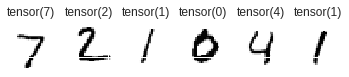

In [0]:
# visualize some images

args = Args()
_, _, _, test_dataset, _ = prepare_dataset(args)
images = test_dataset.test_data[:6]
labels = test_dataset.test_labels[:6]
fig, axes = plt.subplots(1,6)
for axis, img, lbl in zip(axes, images, labels):
    axis.imshow(img)
    axis.set_title(lbl)
    axis.set_yticklabels([])
    axis.set_xticklabels([])
plt.show()


## Training and Testing Code

### Training

In [0]:
def train(model, optimizer, train_loader, epoch, total_minibatch_count,
        train_losses, train_accs):
    # Training for a full epoch

    model.train()
    correct_count, total_loss, total_acc = 0., 0., 0.
    progress_bar = tqdm.tqdm(train_loader, desc='Training')
    
    for batch_idx, (data, target) in enumerate(progress_bar):
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        optimizer.zero_grad()

        # Forward prediction step
        output = model(data)
        loss = F.nll_loss(output, target)

        # Backpropagation step
        loss.backward()
        optimizer.step()

        # The batch has ended, determine the accuracy of the predicted outputs
        pred = output.data.max(1)[1]  

        # target labels and predictions are categorical values from 0 to 9.
        matches = target == pred
        accuracy = matches.float().mean()
        correct_count += matches.sum()

        if args.log_interval != 0 and \
                total_minibatch_count % args.log_interval == 0:

            train_losses.append(loss.data[0])
            train_accs.append(accuracy.data[0])
            
        total_loss += loss.data
        total_acc += accuracy.data
            
        progress_bar.set_description(
            'Epoch: {} loss: {:.4f}, acc: {:.2f}'.format(
                epoch, total_loss / (batch_idx + 1), total_acc / (batch_idx + 1)))
        #progress_bar.refresh()

        total_minibatch_count += 1

    return total_minibatch_count

### Testing

In [0]:
def test(model, test_loader, epoch, total_minibatch_count,
        val_losses, val_accs):
    # Validation Testing
    model.eval()
    test_loss, correct = 0., 0.
    progress_bar = tqdm.tqdm(test_loader, desc='Validation')
    with torch.no_grad():
        for data, target in progress_bar:
            if args.cuda:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').data  # sum up batch loss
            pred = output.data.max(1)[1]  # get the index of the max log-probability
            correct += (target == pred).float().sum()

    test_loss /= len(test_loader.dataset)
    
    acc = correct / len(test_loader.dataset)

    val_losses.append(test_loss)
    val_accs.append(acc)
    
    progress_bar.clear()
    progress_bar.write(
        '\nEpoch: {} validation test results - Average val_loss: {:.4f}, val_acc: {}/{} ({:.2f}%)'.format(
            epoch, test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

    return acc

## Run 

In [0]:
# Run the experiment
def run_experiment(args):

    total_minibatch_count = 0

    torch.manual_seed(args.seed)
    if args.cuda:
        torch.cuda.manual_seed(args.seed)

    train_loader, test_loader, _, _, run_path = prepare_dataset(args)

    epochs_to_run = args.epochs

    # Choose model
    # TODO add all the other models here if their parameter is specified
    if args.model == 'default' or args.model == 'P2Q7DefaultChannelsNet':
        model = Net()
    elif args.model in globals():
        model = globals()[args.model]()
    else:
        raise ValueError('Unknown model type: ' + args.model)

    if args.cuda:
        model.cuda()

    # Choose optimizer
    if args.optimizer == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    elif args.optimizer == 'adam':
        optimizer = optim.Adam(model.parameters())
    elif args.optimizer == 'rmsprop':
        optimizer = optim.RMSprop(model.parameters())
    else:
        raise ValueError('Unsupported optimizer: ' + args.optimizer)

    # Run the primary training loop, starting with validation accuracy of 0
    val_acc = 0
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    for epoch in range(1, epochs_to_run + 1):
        
        # train for 1 epoch
        total_minibatch_count = train(model, optimizer, train_loader,
                                    epoch, total_minibatch_count,
                                    train_losses, train_accs)
        # validate progress on test dataset
        val_acc = test(model, test_loader, epoch, total_minibatch_count,
                       val_losses, val_accs)
        
    fig, axes = plt.subplots(1,4, figsize=(13,4))
    # plot the losses and acc
    plt.title(args.name)
    axes[0].plot(train_losses)
    axes[0].set_title("Loss")
    axes[1].plot(train_accs)
    axes[1].set_title("Acc")
    axes[2].plot(val_losses)
    axes[2].set_title("Val loss")
    axes[3].plot(val_accs)
    axes[3].set_title("Val Acc")
    
    # Write to csv file
    with open(os.path.join(run_path + 'train.csv'), 'w') as f:
        csvw = csv.writer(f, delimiter=',')
        for loss, acc in zip(train_losses, train_accs):
            csvw.writerow((loss, acc))
            
    # Save the entire model
    if args.model == 'P2Q13UltimateNet':
      path = os.path.join(run_path + 'ultimate_net.pt')
      print("Saving Model to: ", path)
      torch.save(model.state_dict(), path)

    # Predict and Test
    images, labels = next(iter(test_loader))
    if args.cuda:
        images, labels = images.cuda(), labels.cuda()
    output = model(images)
    predicted = torch.max(output, 1)[1]
    fig, axes = plt.subplots(1,6)
    for i, (axis, img, lbl) in enumerate(zip(axes, images, predicted)):
        if i > 5:
            break
        img = img.permute(1,2,0).squeeze()
        axis.imshow(img)
        axis.set_title(lbl.data)
        axis.set_yticklabels([])
        axis.set_xticklabels([])
            
    if args.dataset == 'fashion_mnist' and val_acc > 0.92 and val_acc <= 1.0:
        print("Congratulations, you beat the Question 13 minimum of 92"
            "with ({:.2f}%) validation accuracy!".format(val_acc))

## Just Evaluation

In [0]:
# Run the experiment
def run_eval(args, model):

    total_minibatch_count = 0

    torch.manual_seed(args.seed)
    if args.cuda:
        torch.cuda.manual_seed(args.seed)

    train_loader, test_loader, _, _, run_path = prepare_dataset(args)

    epochs_to_run = 1
    
    if args.cuda:
        model.cuda()

    # Run the primary training loop, starting with validation accuracy of 0
    val_acc = 0
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    for epoch in range(1, epochs_to_run + 1):
        
        # validate progress on test dataset
        val_acc = test(model, test_loader, epoch, total_minibatch_count,
                       val_losses, val_accs)
        
    fig, axes = plt.subplots(1,4, figsize=(13,4))
    # plot the losses and acc
    plt.title(args.name)
    axes[0].plot(train_losses)
    axes[0].set_title("Loss")
    axes[1].plot(train_accs)
    axes[1].set_title("Acc")
    axes[2].plot(val_losses)
    axes[2].set_title("Val loss")
    axes[3].plot(val_accs)
    axes[3].set_title("Val Acc")

    # Predict and Test
    images, labels = next(iter(test_loader))
    if args.cuda:
        images, labels = images.cuda(), labels.cuda()
    output = model(images)
    predicted = torch.max(output, 1)[1]
    fig, axes = plt.subplots(1,6)
    for i, (axis, img, lbl) in enumerate(zip(axes, images, predicted)):
        if i > 5:
            break
        img = img.permute(1,2,0).squeeze()
        axis.imshow(img)
        axis.set_title(lbl.data)
        axis.set_yticklabels([])
        axis.set_xticklabels([])

# Questions


For each of the following questions (#1-8):

* Run on Fashion-MNIST unless the instructions say otherwise.
* Include a screenshot of your graphs for each situation.
* Give a very brief explanation of effect of this hyperparameter change
  * This requires that you understand and be able to articulate the difference between the various metrics, as well as the conclusions you can reach based on them.
  * The labels and screenshots must be clear.
* After each question, return to the parameters to their original settings unless the next question says otherwise.




#### Default Args


```python 
name='mnist
batch_size=64
test_batch_size=1000,
epochs=10
lr=0.01
optimizer='sgd'
momentum=0.5,
seed=1
log_interval=100
dataset='mnist',
data_dir='/content/drive/My Drive/cs482/data'
model='default',
cuda=True```

## Varying Datasets 



### Question 1
* Compare the performance of mnist and fashion-mnist 

#### Answer

Our model for mnist can easily get $98\%$ validation accuracy while the fashion mnist model only reached a worse $87\%$ accuracy on the same model. This shows that fashion mnist is a harder dataset to learn the labels of than mnist, as the authors of the fashion mnist paper pointed out.

*   **MNIST**
![alt text](https://github.com/AlexDaIii/fashion_mnist_cs482/blob/master/Programming/p02_deep_learning_scs/01_mnist.png?raw=true "MNIST")


*  **Fashion MNIST**
![alt text](https://github.com/AlexDaIii/fashion_mnist_cs482/blob/master/Programming/p02_deep_learning_scs/01_fashion_mnist.png?raw=true "Fashion MNIST")

#### Code

##### MNIST

Training:   0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 1 validation test results - Average val_loss: 0.1556, val_acc: 9527.0/10000 (95.27%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 2 validation test results - Average val_loss: 0.0953, val_acc: 9688.0/10000 (96.88%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 3 validation test results - Average val_loss: 0.0758, val_acc: 9762.0/10000 (97.62%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 4 validation test results - Average val_loss: 0.0635, val_acc: 9801.0/10000 (98.01%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 5 validation test results - Average val_loss: 0.0562, val_acc: 9825.0/10000 (98.25%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 6 validation test results - Average val_loss: 0.0502, val_acc: 9832.0/10000 (98.32%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 7 validation test results - Average val_loss: 0.0475, val_acc: 9852.0/10000 (98.52%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 8 validation test results - Average val_loss: 0.0457, val_acc: 9851.0/10000 (98.51%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 9 validation test results - Average val_loss: 0.0385, val_acc: 9880.0/10000 (98.80%)


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]



Epoch: 10 validation test results - Average val_loss: 0.0392, val_acc: 9879.0/10000 (98.79%)


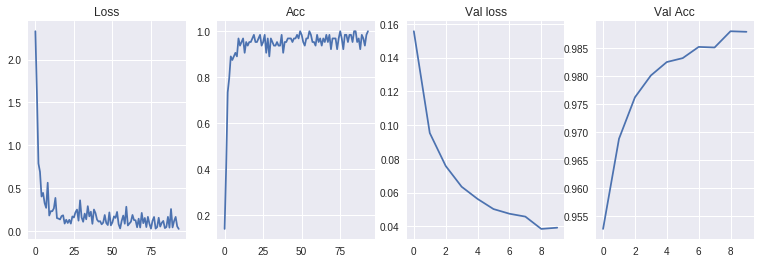

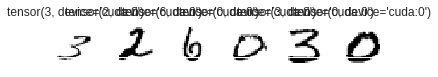

In [0]:
run_experiment(Args())

##### Fashion MNIST


Training:   0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 1 validation test results - Average val_loss: 0.6365, val_acc: 7519.0/10000 (75.19%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 2 validation test results - Average val_loss: 0.5196, val_acc: 8034.0/10000 (80.34%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 3 validation test results - Average val_loss: 0.4898, val_acc: 8127.0/10000 (81.27%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 4 validation test results - Average val_loss: 0.4421, val_acc: 8378.0/10000 (83.78%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 5 validation test results - Average val_loss: 0.4164, val_acc: 8454.0/10000 (84.54%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 6 validation test results - Average val_loss: 0.4019, val_acc: 8531.0/10000 (85.31%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 7 validation test results - Average val_loss: 0.3830, val_acc: 8602.0/10000 (86.02%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 8 validation test results - Average val_loss: 0.3756, val_acc: 8650.0/10000 (86.50%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 9 validation test results - Average val_loss: 0.3596, val_acc: 8665.0/10000 (86.65%)


Validation: 100%|██████████| 10/10 [00:01<00:00,  6.07it/s]



Epoch: 10 validation test results - Average val_loss: 0.3556, val_acc: 8707.0/10000 (87.07%)


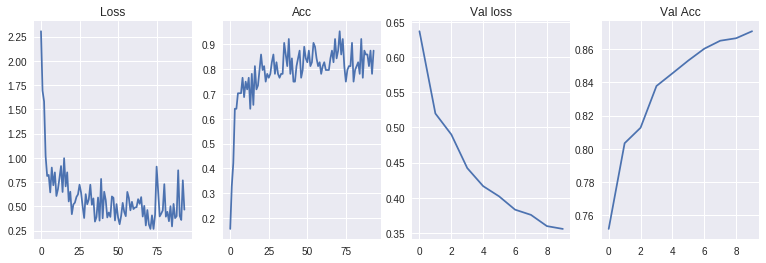

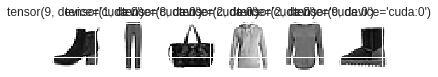

In [0]:
run_experiment(Args(name='fashion_mnist', dataset='fashion_mnist'))


## Varying Hyperparameters 





### Question 2
* Train for twice as many epochs for both mnist and fashion_mnist.
    - Fashion 20 epochs, MNIST 20 epochs 
    - How does the number of epochs change things for each dataset?
    

#### Answer

With this model, MNIST was able to get a little over $99\%$ validationaccuracy, improving from before. There is a little dip in accuracy at the end which may mean we are overfitting a little.

On Fashion MNIST 20 epochs improved accuracy from $87\%$ to $88\%$, a pecent change of about $2\%$. From the graphs, it does not seem like it is overfitting and we may have been able to improve accruacy a little more with a few more epochs.

The number of epochs (times number of iterations per epoch because we are splitting the data into mini-batches) tells how many gradient descent updates we will be doing. More epochs means we are performing more updates. Running for too few epochs can lead to underfitting because we may have not yet reached a minimia, but too many epochs can lead to overfitting the training data.
    
*   **MNIST 20 Epoch**
![alt text](https://github.com/AlexDaIii/fashion_mnist_cs482/blob/master/Programming/p02_deep_learning_scs/02_mnist_20epoch.png?raw=true "MNIST 20 Epoch")
*   **Fashion MNIST 20 Epoch**
![alt text](https://github.com/AlexDaIii/fashion_mnist_cs482/blob/master/Programming/p02_deep_learning_scs/02_fashion_mnist_20epoch.png?raw=true "Fashion MNIST 20 Epoch")

#### Code

##### MNIST 20 Epochs

Training:   0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 1 validation test results - Average val_loss: 0.1550, val_acc: 9530.0/10000 (95.30%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 2 validation test results - Average val_loss: 0.0950, val_acc: 9691.0/10000 (96.91%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 3 validation test results - Average val_loss: 0.0751, val_acc: 9752.0/10000 (97.52%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 4 validation test results - Average val_loss: 0.0624, val_acc: 9805.0/10000 (98.05%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 5 validation test results - Average val_loss: 0.0558, val_acc: 9835.0/10000 (98.35%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 6 validation test results - Average val_loss: 0.0501, val_acc: 9821.0/10000 (98.21%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 7 validation test results - Average val_loss: 0.0509, val_acc: 9842.0/10000 (98.42%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 8 validation test results - Average val_loss: 0.0446, val_acc: 9863.0/10000 (98.63%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 9 validation test results - Average val_loss: 0.0387, val_acc: 9882.0/10000 (98.82%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 10 validation test results - Average val_loss: 0.0392, val_acc: 9879.0/10000 (98.79%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 11 validation test results - Average val_loss: 0.0352, val_acc: 9894.0/10000 (98.94%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 12 validation test results - Average val_loss: 0.0426, val_acc: 9872.0/10000 (98.72%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 13 validation test results - Average val_loss: 0.0337, val_acc: 9892.0/10000 (98.92%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 14 validation test results - Average val_loss: 0.0321, val_acc: 9904.0/10000 (99.04%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 15 validation test results - Average val_loss: 0.0336, val_acc: 9894.0/10000 (98.94%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 16 validation test results - Average val_loss: 0.0311, val_acc: 9908.0/10000 (99.08%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 17 validation test results - Average val_loss: 0.0294, val_acc: 9913.0/10000 (99.13%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 18 validation test results - Average val_loss: 0.0328, val_acc: 9903.0/10000 (99.03%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 19 validation test results - Average val_loss: 0.0306, val_acc: 9899.0/10000 (98.99%)


Validation: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]



Epoch: 20 validation test results - Average val_loss: 0.0323, val_acc: 9901.0/10000 (99.01%)


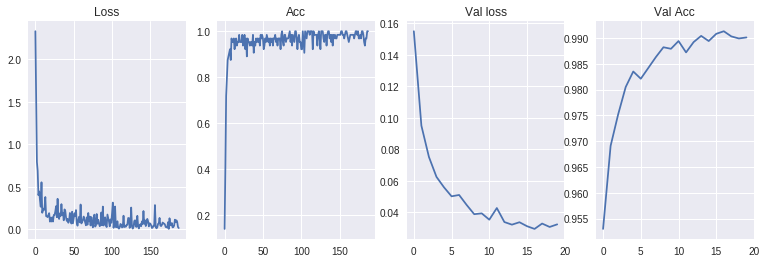

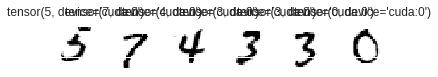

In [0]:
run_experiment(Args(name='mnist_20_epoch', epochs=20))

##### Fashion MNIST 20 Epochs


Training:   0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 1 validation test results - Average val_loss: 0.6418, val_acc: 7503.0/10000 (75.03%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 2 validation test results - Average val_loss: 0.5195, val_acc: 8018.0/10000 (80.18%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 3 validation test results - Average val_loss: 0.4840, val_acc: 8174.0/10000 (81.74%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 4 validation test results - Average val_loss: 0.4400, val_acc: 8401.0/10000 (84.01%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 5 validation test results - Average val_loss: 0.4171, val_acc: 8439.0/10000 (84.39%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 6 validation test results - Average val_loss: 0.3982, val_acc: 8533.0/10000 (85.33%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 7 validation test results - Average val_loss: 0.3820, val_acc: 8606.0/10000 (86.06%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 8 validation test results - Average val_loss: 0.3756, val_acc: 8643.0/10000 (86.43%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 9 validation test results - Average val_loss: 0.3563, val_acc: 8688.0/10000 (86.88%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 10 validation test results - Average val_loss: 0.3520, val_acc: 8713.0/10000 (87.13%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 11 validation test results - Average val_loss: 0.3425, val_acc: 8757.0/10000 (87.57%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 12 validation test results - Average val_loss: 0.3428, val_acc: 8723.0/10000 (87.23%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 13 validation test results - Average val_loss: 0.3366, val_acc: 8766.0/10000 (87.66%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 14 validation test results - Average val_loss: 0.3429, val_acc: 8690.0/10000 (86.90%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 15 validation test results - Average val_loss: 0.3295, val_acc: 8807.0/10000 (88.07%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 16 validation test results - Average val_loss: 0.3392, val_acc: 8743.0/10000 (87.43%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 17 validation test results - Average val_loss: 0.3310, val_acc: 8762.0/10000 (87.62%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 18 validation test results - Average val_loss: 0.3132, val_acc: 8871.0/10000 (88.71%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 19 validation test results - Average val_loss: 0.3172, val_acc: 8828.0/10000 (88.28%)


Validation: 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]



Epoch: 20 validation test results - Average val_loss: 0.3065, val_acc: 8887.0/10000 (88.87%)


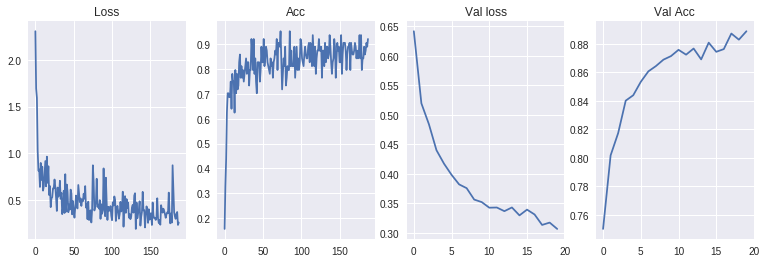

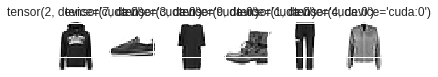

In [0]:
run_experiment(Args(name='fashion_mnist_20_epoch', epochs=20, dataset='fashion_mnist'))

### Question 3
* Change the SGD Learning Rate by a factor of
  * 0.1x
  ```python 
  lr=0.001```
  * 1x (Default)
    ```python 
  lr=0.01```
  * 10x
    ```python 
  lr=0.1```

#### Answer

Decreasing the learning rate *(0.1x)* decreased accruacy from $87\%$ to $78\%$, a percent change of about $-10\%$. This is because each gradient update is smaller, so we'd expect convergence to some minimum to be slower. 

Increasing the learning rate *(10x)* (surprisingly) increased accruacy from $87.07\%$ to $87.74\%$, a percent change of about $0.77\%$. Increasing the learning rate can increase convergece because it means we are taking a larger step in the opposite direction of the gradient. However, the problem with that is that we may bounce out of a minimia because our step was too big. We can see that in the graph when the accuracy suddenly drops at around the $5^{th}$ epoch. 

*   **Fashion MNIST Learning Rate 0.001 (0.1x)**
![alt text](https://github.com/AlexDaIii/fashion_mnist_cs482/blob/master/Programming/p02_deep_learning_scs/03_fashion_mnist_lr_e-03.png?raw=true "Fashion MNIST Learning Rate 0.001")

*   **Fashion MNIST Learning Rate 0.01 (1x)**
![alt text](https://github.com/AlexDaIii/fashion_mnist_cs482/blob/master/Programming/p02_deep_learning_scs/01_fashion_mnist.png?raw=true "Fashion MNIST Learning Rate 0.01")
   

*   **Fashion MNIST Learning Rate 0.1 (10x)**
![alt text](https://github.com/AlexDaIii/fashion_mnist_cs482/blob/master/Programming/p02_deep_learning_scs/03_fashion_mnist_lr_e-01.png?raw=true "Fashion MNIST Learning Rate 0.1")
 

#### Code

##### Fashion MNIST lr 0.001

Training:   0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 1 validation test results - Average val_loss: 1.4324, val_acc: 5824.0/10000 (58.24%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 2 validation test results - Average val_loss: 0.9162, val_acc: 6809.0/10000 (68.09%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 3 validation test results - Average val_loss: 0.7804, val_acc: 7210.0/10000 (72.10%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 4 validation test results - Average val_loss: 0.7118, val_acc: 7379.0/10000 (73.79%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 5 validation test results - Average val_loss: 0.6672, val_acc: 7515.0/10000 (75.15%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 6 validation test results - Average val_loss: 0.6406, val_acc: 7600.0/10000 (76.00%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 7 validation test results - Average val_loss: 0.6162, val_acc: 7681.0/10000 (76.81%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 8 validation test results - Average val_loss: 0.6003, val_acc: 7700.0/10000 (77.00%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 9 validation test results - Average val_loss: 0.5860, val_acc: 7786.0/10000 (77.86%)


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.76it/s]



Epoch: 10 validation test results - Average val_loss: 0.5677, val_acc: 7839.0/10000 (78.39%)


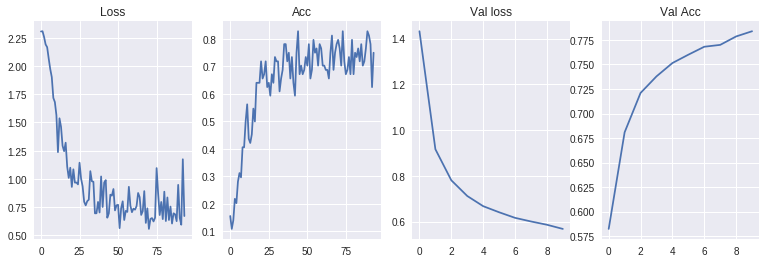

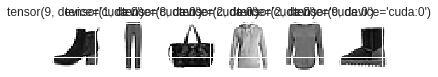

In [0]:
run_experiment(Args(name='fashion_mnist_lr=0.001', lr=0.001, dataset='fashion_mnist'))

##### Fashion MNIST lr 0.1

Training:   0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 1 validation test results - Average val_loss: 0.4889, val_acc: 8189.0/10000 (81.89%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 2 validation test results - Average val_loss: 0.3958, val_acc: 8565.0/10000 (85.65%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 3 validation test results - Average val_loss: 0.3782, val_acc: 8589.0/10000 (85.89%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 4 validation test results - Average val_loss: 0.3625, val_acc: 8639.0/10000 (86.39%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 5 validation test results - Average val_loss: 0.3467, val_acc: 8747.0/10000 (87.47%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 6 validation test results - Average val_loss: 0.3691, val_acc: 8647.0/10000 (86.47%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 7 validation test results - Average val_loss: 0.3578, val_acc: 8724.0/10000 (87.24%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 8 validation test results - Average val_loss: 0.3410, val_acc: 8764.0/10000 (87.64%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 9 validation test results - Average val_loss: 0.3438, val_acc: 8779.0/10000 (87.79%)


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.92it/s]



Epoch: 10 validation test results - Average val_loss: 0.3387, val_acc: 8774.0/10000 (87.74%)


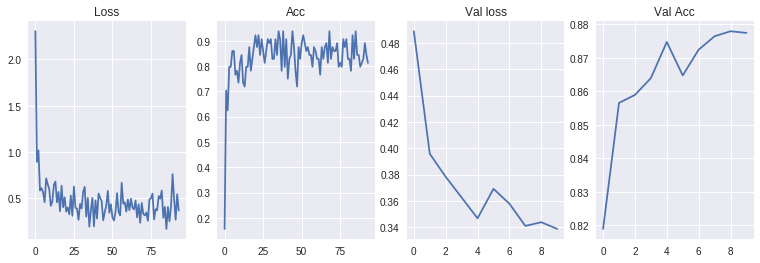

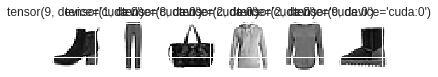

In [0]:
run_experiment(Args(name='fashion_mnist_lr=0.1', lr=0.1, dataset='fashion_mnist'))

### Question 4
* Compare Optimizers
    * SGD (Default)
```python 
  optimizer='sgd'```
    * Adam
```python 
  optimizer='adam'```
    * Rmsprop
  ```python 
  optimizer='rmsprop'```


#### Answer


By *SGD* I assumed you meant the default SDG+Momentum. By default, Pytorch SGD's momentum is set to 0. With SDG+Momentum, the idea is to smooth out oscillations when we are traversing (hyper?)ravines. These ossilations slows down gradient descent and prevent us from using a larger learning rate - it might ossoliate out of the minima. By adding momentum, it allows the gradient to build up velocity in the direction where the gradient is gentle and consistent.

Using the *Adam* optimizer improved our accuracy from $87\%$ to $89\%$, a percent change of about $2.4\%$. It is suppoed to be a combination of the Momentum and RMSProp idea by adding past gradients while also dividing the gradient by the size of the past gradients. Also it is generally supposed to be better than regular SGD. 

The *RMSProp* optimizer, with its default values, could not successfully optimize our model. It seemed like the model was just randomly guessing after each epoch. However, I haven't tried it with a lower learning rate. According to the slides RMSProp was proposed in, the basic intuition is that it takes a step using the gradient divided by the size of the gradient. This helps damps out the ossilations like with Momentum and allows for faster conergence.

    
*   **SGD**
![alt text](https://github.com/AlexDaIii/fashion_mnist_cs482/blob/master/Programming/p02_deep_learning_scs/01_fashion_mnist.png?raw=true "SGD")

*   **Adam**
![alt text](https://github.com/AlexDaIii/fashion_mnist_cs482/blob/master/Programming/p02_deep_learning_scs/04_fashion_mnist_adam.png?raw=true "Adam")
   
*   **RMSProp**
![alt text](https://github.com/AlexDaIii/fashion_mnist_cs482/blob/master/Programming/p02_deep_learning_scs/04_fashion_mnist_rmsprop.png?raw=true "RMSProp")

#### Code

##### Fashion MNIST Adam

Training:   0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 1 validation test results - Average val_loss: 0.4643, val_acc: 8283.0/10000 (82.83%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 2 validation test results - Average val_loss: 0.3967, val_acc: 8553.0/10000 (85.53%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 3 validation test results - Average val_loss: 0.3625, val_acc: 8667.0/10000 (86.67%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 4 validation test results - Average val_loss: 0.3474, val_acc: 8715.0/10000 (87.15%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 5 validation test results - Average val_loss: 0.3303, val_acc: 8808.0/10000 (88.08%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 6 validation test results - Average val_loss: 0.3206, val_acc: 8824.0/10000 (88.24%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 7 validation test results - Average val_loss: 0.3199, val_acc: 8845.0/10000 (88.45%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 8 validation test results - Average val_loss: 0.3111, val_acc: 8858.0/10000 (88.58%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 9 validation test results - Average val_loss: 0.3048, val_acc: 8911.0/10000 (89.11%)


Validation: 100%|██████████| 10/10 [00:01<00:00,  6.13it/s]



Epoch: 10 validation test results - Average val_loss: 0.2977, val_acc: 8920.0/10000 (89.20%)


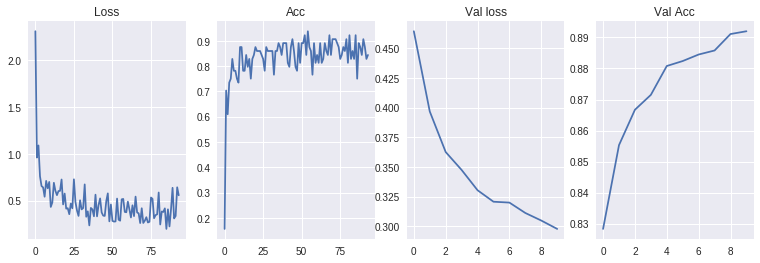

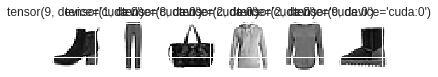

In [0]:
run_experiment(Args(name='fashion_mnist_Adam', optimizer='adam', dataset='fashion_mnist'))

##### Fashion MNIST Rmsprop

Training:   0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 1 validation test results - Average val_loss: 2.3036, val_acc: 1000.0/10000 (10.00%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 2 validation test results - Average val_loss: 2.3032, val_acc: 1000.0/10000 (10.00%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 3 validation test results - Average val_loss: 2.3031, val_acc: 1000.0/10000 (10.00%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 4 validation test results - Average val_loss: 2.3041, val_acc: 1000.0/10000 (10.00%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 5 validation test results - Average val_loss: 2.3030, val_acc: 1000.0/10000 (10.00%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 6 validation test results - Average val_loss: 2.3034, val_acc: 1000.0/10000 (10.00%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 7 validation test results - Average val_loss: 2.3030, val_acc: 1000.0/10000 (10.00%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 8 validation test results - Average val_loss: 2.3030, val_acc: 1000.0/10000 (10.00%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 9 validation test results - Average val_loss: 2.3033, val_acc: 1000.0/10000 (10.00%)


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.82it/s]



Epoch: 10 validation test results - Average val_loss: 2.3030, val_acc: 1000.0/10000 (10.00%)


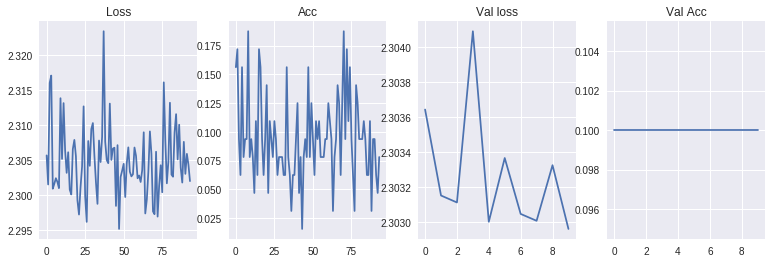

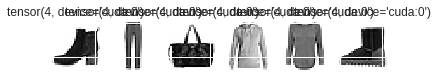

In [0]:
run_experiment(Args(name='fashion_mnist_Rmsprop', optimizer='rmsprop', dataset='fashion_mnist'))

### Question 5
* Set the dropout layer to a dropout rate of
 * 0 
```python
# In default Net class change line to this and rerun cell
x = F.dropout(x, p=0, training=self.training)
```
 * 0.25
 ```python
# In default Net class change line to this and rerun cell
x = F.dropout(x, p=0.25, training=self.training)
```
 * 0.5 (Default) 
 ```python
# In default Net class change line to this and rerun cell
x = F.dropout(x, training=self.training)
```
 * 0.9
 ```python
# In default Net class change line to this and rerun cell
x = F.dropout(x, p=0.9, training=self.training)
```
 * 1
 ```python
# In default Net class change line to this and rerun cell
x = F.dropout(x, p=1, training=self.training)
```

#### Answer 

Dropout is a regularization technique that supposed to reduce overfitting of a network. It removes some of the neurons in the layer with a probablilty of $(1-p)$. So a $p=0$ means we are not dropping out any nodes while a dropout of $1$ means we are dropping out every node. It forces neurons to not be dependent on each other. Also it can be though of as ensamble learning and we are basically training a lot of neural networks at once. 

With a *p=0*, I got a slight improvement with a $88.39\%$ accuracy. This is because adding dropout increases the amount of time it takes to converge. So for the dafault p=0.5 case, we would have to run it more times to get to converge.

With a *p=0.25*, there was a marginal improvement to $87.93\%$ accuracy. It did worse than the p=0 case , but bettter than the p=0.5 case.

With a *p=0.9*, there was a decrease in accuracy to $80\%$. This is probably because we were too aggressive in our dropout rate and the network cannot learn because too many neurons were shut off each epoch. 

With a *p=1*, all nodes dropped out so we were never actually learning every epoch.

*   **p=0**
![alt text](https://github.com/AlexDaIii/fashion_mnist_cs482/blob/master/Programming/p02_deep_learning_scs/05_fashion_mnist_dropout_0-00.png?raw=true "p=0")

*   **p=0.25**
![alt text](https://github.com/AlexDaIii/fashion_mnist_cs482/blob/master/Programming/p02_deep_learning_scs/05_fashion_mnist_dropout_0-25.png?raw=true "p=0.25")
   
*   **p=0.5**
![alt text](https://github.com/AlexDaIii/fashion_mnist_cs482/blob/master/Programming/p02_deep_learning_scs/01_fashion_mnist.png?raw=true "p=0.5")

*   **p=0.9**
![alt text](https://github.com/AlexDaIii/fashion_mnist_cs482/blob/master/Programming/p02_deep_learning_scs/05_fashion_mnist_dropout_0-90.png?raw=true "p=0.9")

*   **p=1.0**
![alt text](https://github.com/AlexDaIii/fashion_mnist_cs482/blob/master/Programming/p02_deep_learning_scs/05_fashion_mnist_dropout_1-00.png?raw=true "p=1.0")

#### Code

##### Fashion MNIST Dropout 0

Training:   0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 1 validation test results - Average val_loss: 0.6219, val_acc: 7676.0/10000 (76.76%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 2 validation test results - Average val_loss: 0.4746, val_acc: 8351.0/10000 (83.51%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 3 validation test results - Average val_loss: 0.4429, val_acc: 8433.0/10000 (84.33%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 4 validation test results - Average val_loss: 0.3879, val_acc: 8618.0/10000 (86.18%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 5 validation test results - Average val_loss: 0.3671, val_acc: 8686.0/10000 (86.86%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 6 validation test results - Average val_loss: 0.3574, val_acc: 8718.0/10000 (87.18%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 7 validation test results - Average val_loss: 0.3477, val_acc: 8779.0/10000 (87.79%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 8 validation test results - Average val_loss: 0.3367, val_acc: 8793.0/10000 (87.93%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 9 validation test results - Average val_loss: 0.3165, val_acc: 8866.0/10000 (88.66%)


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.87it/s]



Epoch: 10 validation test results - Average val_loss: 0.3173, val_acc: 8839.0/10000 (88.39%)


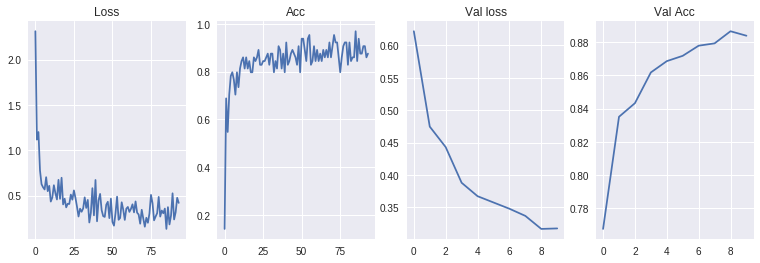

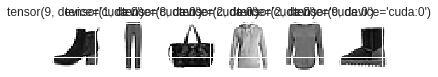

In [0]:
run_experiment(Args(name='fashion_mnist_dropout_0', dataset='fashion_mnist'))

##### Fashion MNSIT Dropout 0.25

Training:   0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 1 validation test results - Average val_loss: 0.6164, val_acc: 7594.0/10000 (75.94%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 2 validation test results - Average val_loss: 0.4980, val_acc: 8208.0/10000 (82.08%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 3 validation test results - Average val_loss: 0.4621, val_acc: 8290.0/10000 (82.90%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 4 validation test results - Average val_loss: 0.4181, val_acc: 8486.0/10000 (84.86%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 5 validation test results - Average val_loss: 0.3914, val_acc: 8557.0/10000 (85.57%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 6 validation test results - Average val_loss: 0.3796, val_acc: 8629.0/10000 (86.29%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 7 validation test results - Average val_loss: 0.3617, val_acc: 8687.0/10000 (86.87%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 8 validation test results - Average val_loss: 0.3583, val_acc: 8684.0/10000 (86.84%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 9 validation test results - Average val_loss: 0.3402, val_acc: 8754.0/10000 (87.54%)


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.90it/s]



Epoch: 10 validation test results - Average val_loss: 0.3314, val_acc: 8793.0/10000 (87.93%)


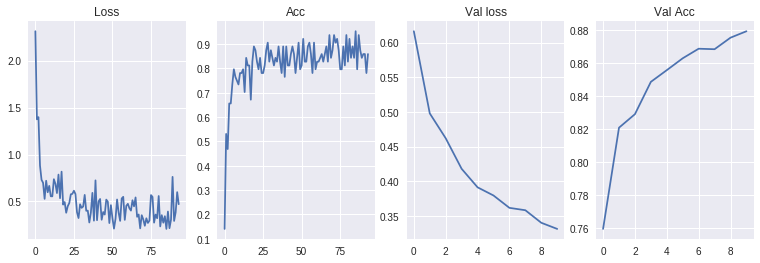

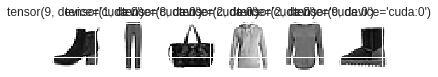

In [0]:
run_experiment(Args(name='fashion_mnist_dropout_0.25', dataset='fashion_mnist'))

##### Fashion MNIST Dropout 0.9

Training:   0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 1 validation test results - Average val_loss: 0.9841, val_acc: 7045.0/10000 (70.45%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 2 validation test results - Average val_loss: 0.8413, val_acc: 7369.0/10000 (73.69%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 3 validation test results - Average val_loss: 0.7479, val_acc: 7556.0/10000 (75.56%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 4 validation test results - Average val_loss: 0.7112, val_acc: 7745.0/10000 (77.45%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 5 validation test results - Average val_loss: 0.6678, val_acc: 7830.0/10000 (78.30%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 6 validation test results - Average val_loss: 0.6595, val_acc: 7868.0/10000 (78.68%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 7 validation test results - Average val_loss: 0.6286, val_acc: 7964.0/10000 (79.64%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 8 validation test results - Average val_loss: 0.6183, val_acc: 8024.0/10000 (80.24%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 9 validation test results - Average val_loss: 0.6032, val_acc: 8015.0/10000 (80.15%)


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.96it/s]



Epoch: 10 validation test results - Average val_loss: 0.5866, val_acc: 8063.0/10000 (80.63%)


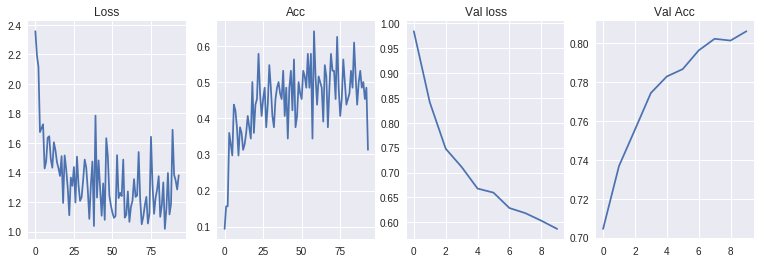

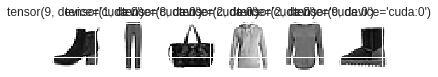

In [0]:
run_experiment(Args(name='fashion_mnist_dropout_0.9', dataset='fashion_mnist'))

##### Fashion MNIST Dropout 1

Training:   0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 1 validation test results - Average val_loss: 2.2969, val_acc: 1704.0/10000 (17.04%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 2 validation test results - Average val_loss: 2.2965, val_acc: 1629.0/10000 (16.29%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 3 validation test results - Average val_loss: 2.2969, val_acc: 1650.0/10000 (16.50%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 4 validation test results - Average val_loss: 2.2967, val_acc: 1715.0/10000 (17.15%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 5 validation test results - Average val_loss: 2.2968, val_acc: 1636.0/10000 (16.36%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 6 validation test results - Average val_loss: 2.2966, val_acc: 1654.0/10000 (16.54%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 7 validation test results - Average val_loss: 2.2967, val_acc: 1631.0/10000 (16.31%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 8 validation test results - Average val_loss: 2.2968, val_acc: 1613.0/10000 (16.13%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 9 validation test results - Average val_loss: 2.2968, val_acc: 1647.0/10000 (16.47%)


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.69it/s]



Epoch: 10 validation test results - Average val_loss: 2.2967, val_acc: 1645.0/10000 (16.45%)


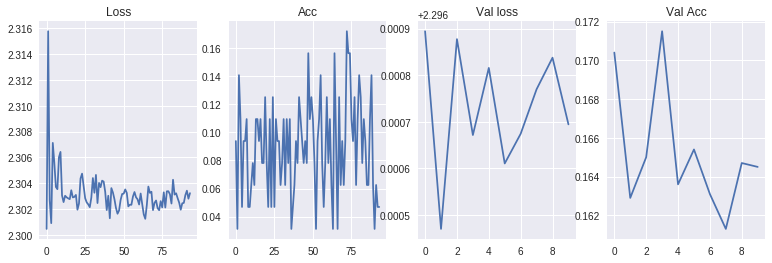

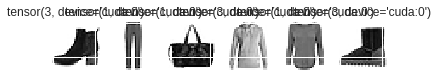

In [0]:
run_experiment(Args(name='fashion_mnist_dropout_1', dataset='fashion_mnist'))

### Question 6
* Change the batch size by a factor of:
     * 1/8x
``` python 
batch_size=8```
     * 1x (Default)
 ``` python 
batch_size=64```
     * 8x
``` python 
batch_size=512```

#### Answer

Some advantages of SGD are that it takes less memory during each iteration, it can converge faster beacuse we are taking more gradient steps, and it can jump out of a local minima to get to a better minima. Increasing batch size increases the amount of memory needed during the step. Decreasing batch size; however, increases noise. 

With the *batch size=8* we can see from the graphs that it is a lot more noisy. Also we see that during epoch 5 and 6, we jumped out of the previous local minima and got worse accuracy before going back into a minima. Accruacy also increased to $88.75\%$ from the batch_size=64 case since we were performaing more gradient updates so we converged faster or we just happened to go to a better minima. 

With the *batch size=512* we can see from the graphs that the loss and accuracy each update was a lot more smooth because we were averaging over more data. Accuracy decreased to $78\%$ beacuse we had less gradient updates so we would expect slower convergence. Also since we were averaging over more examples, we may have never been able to get out of a local minima because it looks like from the graphs we have converged.

*   **batch_size=8 (1/8x)**
![alt text](https://github.com/AlexDaIii/fashion_mnist_cs482/blob/master/Programming/p02_deep_learning_scs/06_fashion_mnist_batchsize_008.png?raw=true "batch_size=8")

*   **batch_size=64 (1x)**
![alt text](https://github.com/AlexDaIii/fashion_mnist_cs482/blob/master/Programming/p02_deep_learning_scs/01_fashion_mnist.png?raw=true "batch_size=64")
   
*   **batch_size=512 (8x)**
![alt text](https://github.com/AlexDaIii/fashion_mnist_cs482/blob/master/Programming/p02_deep_learning_scs/06_fashion_mnist_batchsize_512.png?raw=true "batch_size=512")


#### Code

##### Fashion MNIST batch size 8

Training:   0%|          | 0/7500 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
Training:   0%|          | 0/7500 [00:00<?, ?it/s]


Epoch: 1 validation test results - Average val_loss: 0.4262, val_acc: 8453.0/10000 (84.53%)


Training:   0%|          | 0/7500 [00:00<?, ?it/s]


Epoch: 2 validation test results - Average val_loss: 0.3843, val_acc: 8599.0/10000 (85.99%)


Training:   0%|          | 0/7500 [00:00<?, ?it/s]


Epoch: 3 validation test results - Average val_loss: 0.3665, val_acc: 8616.0/10000 (86.16%)


Training:   0%|          | 0/7500 [00:00<?, ?it/s]


Epoch: 4 validation test results - Average val_loss: 0.3509, val_acc: 8692.0/10000 (86.92%)


Training:   0%|          | 0/7500 [00:00<?, ?it/s]


Epoch: 5 validation test results - Average val_loss: 0.3309, val_acc: 8769.0/10000 (87.69%)


Training:   0%|          | 0/7500 [00:00<?, ?it/s]


Epoch: 6 validation test results - Average val_loss: 0.3461, val_acc: 8732.0/10000 (87.32%)


Training:   0%|          | 0/7500 [00:00<?, ?it/s]


Epoch: 7 validation test results - Average val_loss: 0.3453, val_acc: 8768.0/10000 (87.68%)


Training:   0%|          | 0/7500 [00:00<?, ?it/s]


Epoch: 8 validation test results - Average val_loss: 0.3258, val_acc: 8802.0/10000 (88.02%)


Training:   0%|          | 0/7500 [00:00<?, ?it/s]


Epoch: 9 validation test results - Average val_loss: 0.3182, val_acc: 8860.0/10000 (88.60%)


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.99it/s]



Epoch: 10 validation test results - Average val_loss: 0.3106, val_acc: 8875.0/10000 (88.75%)


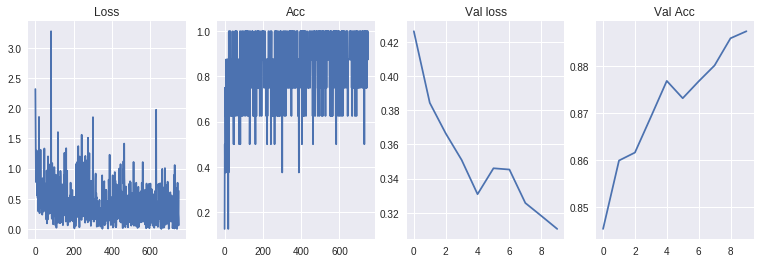

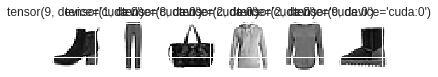

In [0]:
run_experiment(Args(name='fashion_mnist_batchsize=8', batch_size=8, dataset='fashion_mnist'))

##### Fashion MNIST batch size 512

Training:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
Training:   0%|          | 0/118 [00:00<?, ?it/s]


Epoch: 1 validation test results - Average val_loss: 1.2327, val_acc: 6160.0/10000 (61.60%)


Training:   0%|          | 0/118 [00:00<?, ?it/s]


Epoch: 2 validation test results - Average val_loss: 0.8655, val_acc: 6878.0/10000 (68.78%)


Training:   0%|          | 0/118 [00:00<?, ?it/s]


Epoch: 3 validation test results - Average val_loss: 0.7409, val_acc: 7262.0/10000 (72.62%)


Training:   0%|          | 0/118 [00:00<?, ?it/s]


Epoch: 4 validation test results - Average val_loss: 0.6817, val_acc: 7436.0/10000 (74.36%)


Training:   0%|          | 0/118 [00:00<?, ?it/s]


Epoch: 5 validation test results - Average val_loss: 0.6716, val_acc: 7422.0/10000 (74.22%)


Training:   0%|          | 0/118 [00:00<?, ?it/s]


Epoch: 6 validation test results - Average val_loss: 0.6125, val_acc: 7681.0/10000 (76.81%)


Training:   0%|          | 0/118 [00:00<?, ?it/s]


Epoch: 7 validation test results - Average val_loss: 0.6020, val_acc: 7752.0/10000 (77.52%)


Training:   0%|          | 0/118 [00:00<?, ?it/s]


Epoch: 8 validation test results - Average val_loss: 0.5762, val_acc: 7817.0/10000 (78.17%)


Training:   0%|          | 0/118 [00:00<?, ?it/s]


Epoch: 9 validation test results - Average val_loss: 0.5747, val_acc: 7759.0/10000 (77.59%)


Validation: 100%|██████████| 10/10 [00:01<00:00,  6.05it/s]



Epoch: 10 validation test results - Average val_loss: 0.5586, val_acc: 7822.0/10000 (78.22%)


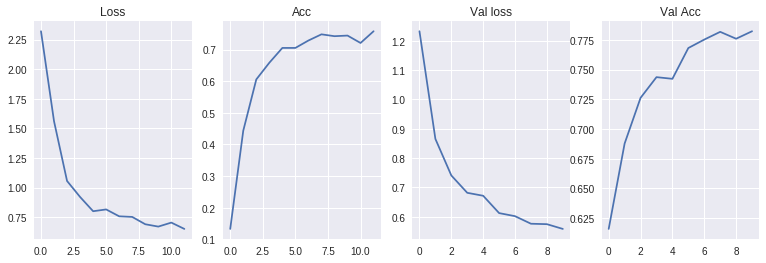

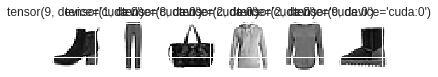

In [0]:
run_experiment(Args(name='fashion_mnist_batchsize=512', batch_size=512, dataset='fashion_mnist'))

### Question 7 
* Change the number of output channels in each convolution and the first Linear layer.
    * 0.5x
   ```python 
model='P2Q7HalfChannelsNet' ```
    * 1x (Default)
    * 2x
    ```python 
model='P2Q7DoubleChannelsNet' ```
    - Note: The input values of each layer will need to match the previous layer.
    - You'll need to implement `P2Q7HalfChannelsNet` and `P2Q7DoubleChannelsNet`.

#### Answer

Output channels are the number of kernels that will be convolved with the input. More channels means more parameters that the network needs to learn. The number of parameters is constant with respect to the width and height of the input image. 

The number of parameters in a CNN is: <br>
$P = W + B$ <br>
$W = K^2 *N * C$ <br>
$B = N$ <br>
Where $W$ is the number of weights, $B$ is number of biases. $K$ is kernel size. $N$ is number of output channels. $C$ is number of input channels.

The HalfChannelsNet's accuracy decreased to $85\%$. This is because the probably because model cannot fully explain the data so there - there is high bias. 

The DoubleChannelsNet's accuracy slightly increased to $87.45\%$. It seems like training and validation accuracy is still going up. This suggests the original model is underfitting the data and a network with more parameters may be better at explaining the data. 


*   **HalfChannelsNet**
![alt text](https://github.com/AlexDaIii/fashion_mnist_cs482/blob/master/Programming/p02_deep_learning_scs/07_fashion_mnist_half_channel_net.png?raw=true "HalfChannelsNet")

*   **DoubleChannelsNet**
![alt text](https://github.com/AlexDaIii/fashion_mnist_cs482/blob/master/Programming/p02_deep_learning_scs/07_fashion_mnist_double_channel_net.png?raw=true "DoubleChannelsNet")


#### Code

##### P2Q7HalfChannelsNet

Training:   0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 1 validation test results - Average val_loss: 0.6416, val_acc: 7418.0/10000 (74.18%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 2 validation test results - Average val_loss: 0.5469, val_acc: 7878.0/10000 (78.78%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 3 validation test results - Average val_loss: 0.5253, val_acc: 8069.0/10000 (80.69%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 4 validation test results - Average val_loss: 0.4739, val_acc: 8199.0/10000 (81.99%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 5 validation test results - Average val_loss: 0.4657, val_acc: 8282.0/10000 (82.82%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 6 validation test results - Average val_loss: 0.4388, val_acc: 8376.0/10000 (83.76%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 7 validation test results - Average val_loss: 0.4084, val_acc: 8531.0/10000 (85.31%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 8 validation test results - Average val_loss: 0.4029, val_acc: 8482.0/10000 (84.82%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 9 validation test results - Average val_loss: 0.4164, val_acc: 8477.0/10000 (84.77%)


Validation: 100%|██████████| 10/10 [00:01<00:00,  6.10it/s]



Epoch: 10 validation test results - Average val_loss: 0.3841, val_acc: 8595.0/10000 (85.95%)


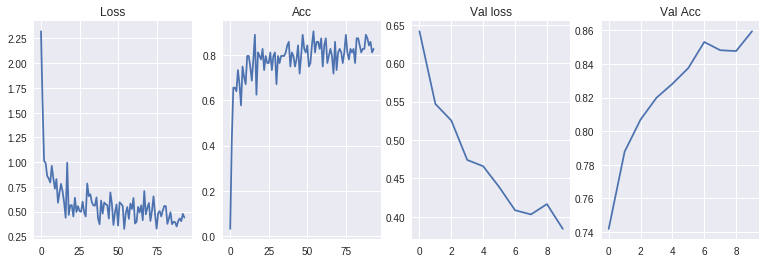

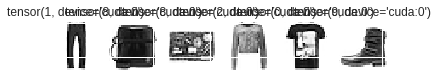

In [0]:
run_experiment(Args(name='fashion_mnist_half_channels_net', model='P2Q7HalfChannelsNet', dataset='fashion_mnist'))

##### P2Q7DoubleChannelsNet

Training:   0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 1 validation test results - Average val_loss: 0.6159, val_acc: 7594.0/10000 (75.94%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 2 validation test results - Average val_loss: 0.5323, val_acc: 8008.0/10000 (80.08%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 3 validation test results - Average val_loss: 0.5040, val_acc: 8188.0/10000 (81.88%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 4 validation test results - Average val_loss: 0.4633, val_acc: 8278.0/10000 (82.78%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 5 validation test results - Average val_loss: 0.4120, val_acc: 8487.0/10000 (84.87%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 6 validation test results - Average val_loss: 0.3977, val_acc: 8570.0/10000 (85.70%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 7 validation test results - Average val_loss: 0.3764, val_acc: 8618.0/10000 (86.18%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 8 validation test results - Average val_loss: 0.3668, val_acc: 8654.0/10000 (86.54%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 9 validation test results - Average val_loss: 0.3522, val_acc: 8724.0/10000 (87.24%)


Validation: 100%|██████████| 10/10 [00:01<00:00,  7.44it/s]



Epoch: 10 validation test results - Average val_loss: 0.3378, val_acc: 8745.0/10000 (87.45%)


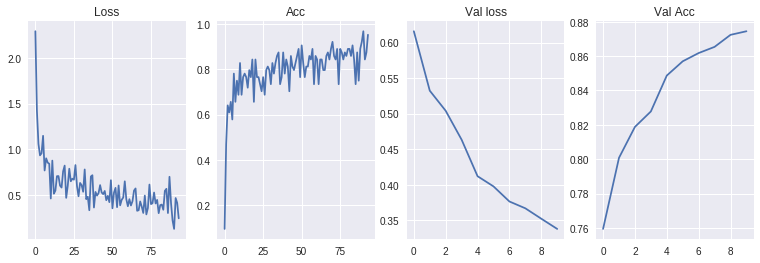

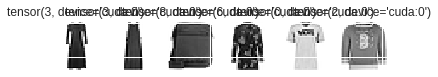

In [0]:
run_experiment(Args(name='fashion_mnist_double_channels_net', model='P2Q7DoubleChannelsNet', dataset='fashion_mnist'))

### Question 8
* Add a Batch Normalization Layer after the first convolution.


#### Answer

Batch norm is supposed to improve optimization by making sure each layer sees standard mean and variance. One intuition as to why it works is because as you train a neural network, the output of the previous layer keeps changing. So the next layer will suffer the problem of covariate shift. Covariate shift is when the distribution of input change but the output remain unchanged. What batch norm does is that it reduces the amount that the values the previous later changes to reduce the problem of covatiate shift so that the netowork learns better.

In this case, batchnorm only slightly increased the accuracy from $87\%$ to $87.29%$. This is beacuse batch norm is not always guarenteed to improve training. 

I placed the batchnorm before the ReLU; however it is apparent up for debate the order of the batch norm layer. The argument for batch norm before the ReLU is that it makes it nice and Gaussian before the activation and some activations like $tanh$ like that. However, with ReLU, sometimes batch norm works better after the ReLU. The argument is that it can bring some of the negative positive if the data is shifted negatively and ReLU is supposed to cut that off. 

*   **BatchNormNet**
![alt text](https://github.com/AlexDaIii/fashion_mnist_cs482/blob/master/Programming/p02_deep_learning_scs/08_fashion_mnist_batchnorm_net.png?raw=true "BatchNormNet")

#### Code

##### BatchnormNet

Training:   0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 1 validation test results - Average val_loss: 0.5876, val_acc: 7731.0/10000 (77.31%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 2 validation test results - Average val_loss: 0.5122, val_acc: 7932.0/10000 (79.32%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 3 validation test results - Average val_loss: 0.4614, val_acc: 8228.0/10000 (82.28%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 4 validation test results - Average val_loss: 0.4288, val_acc: 8417.0/10000 (84.17%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 5 validation test results - Average val_loss: 0.4032, val_acc: 8499.0/10000 (84.99%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 6 validation test results - Average val_loss: 0.3860, val_acc: 8565.0/10000 (85.65%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 7 validation test results - Average val_loss: 0.3841, val_acc: 8588.0/10000 (85.88%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 8 validation test results - Average val_loss: 0.3703, val_acc: 8638.0/10000 (86.38%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 9 validation test results - Average val_loss: 0.3743, val_acc: 8644.0/10000 (86.44%)


Validation: 100%|██████████| 10/10 [00:01<00:00,  6.28it/s]



Epoch: 10 validation test results - Average val_loss: 0.3422, val_acc: 8729.0/10000 (87.29%)


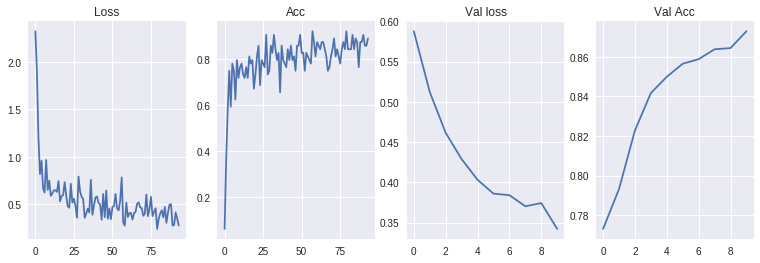

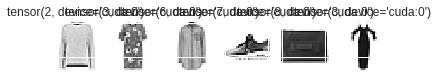

In [0]:
run_experiment(Args(name='fashion_mnist_batchnormNet', model='P2Q8BatchNormNet', dataset='fashion_mnist'))

### Question 9
 * Add a Dropout layer immediately after the Batch Normalization from the previous question.


#### Answer

Adding a dropout layer after the batch normalization decreased accuracy to $85\%$. Just like as before, dropout decreased accruacy because it increases time to convergence. It seems like the training and validation loss is decreasing and the accuracies are still increasing. 

Reading online, Dropout before ReLU and Dropout after ReLU are supposed to produce the same results. Which makes sense because Dropout would have cut out the same neurons either way and ReLU just sets negative values to 0. 


* **Dropout**
![alt text](https://github.com/AlexDaIii/fashion_mnist_cs482/blob/master/Programming/p02_deep_learning_scs/09_fashion_mnist_dropout_net.png?raw=true "DropoutNet")

#### Code

##### DropoutNet

Training:   0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 1 validation test results - Average val_loss: 0.6404, val_acc: 7478.0/10000 (74.78%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 2 validation test results - Average val_loss: 0.5478, val_acc: 7832.0/10000 (78.32%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 3 validation test results - Average val_loss: 0.5079, val_acc: 7950.0/10000 (79.50%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 4 validation test results - Average val_loss: 0.4850, val_acc: 8166.0/10000 (81.66%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 5 validation test results - Average val_loss: 0.4696, val_acc: 8177.0/10000 (81.77%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 6 validation test results - Average val_loss: 0.4514, val_acc: 8310.0/10000 (83.10%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 7 validation test results - Average val_loss: 0.4431, val_acc: 8300.0/10000 (83.00%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 8 validation test results - Average val_loss: 0.4285, val_acc: 8411.0/10000 (84.11%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 9 validation test results - Average val_loss: 0.4153, val_acc: 8478.0/10000 (84.78%)


Validation: 100%|██████████| 10/10 [00:01<00:00,  6.45it/s]



Epoch: 10 validation test results - Average val_loss: 0.3973, val_acc: 8517.0/10000 (85.17%)


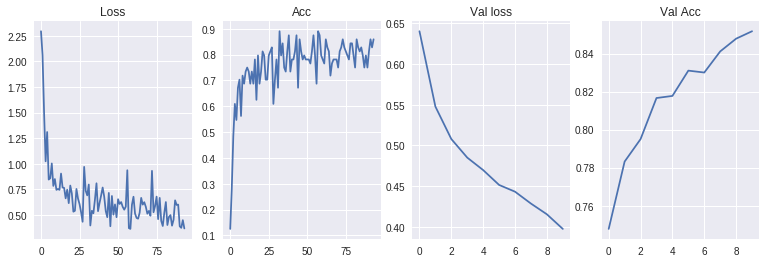

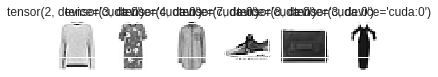

In [0]:
run_experiment(Args(name='fashion_mnist_dropoutNet', model='P2Q9DropoutNet', dataset='fashion_mnist'))

### Question 10
* Move the Batch Normalizaton layer just below the Dropout layer from the previous question.
    - Compare 9 with 10 and explain what happened.
    - You may want to do a quick search of the current literature for this one.


#### Answer

Adding a dropout layer before the batch normalization deceased accuracy to $86.63\%$. However, it increased accuracy vs the batch norm then dropout. 

One argument someone [here](https://stackoverflow.com/questions/39691902/ordering-of-batch-normalization-and-dropout-in-tensorflow) had was that since dropout is supposed to cut off nodes, a batch norm before  dropout would still pass information forward in the network. However, both had worse accuracy which may be explained by this paper: https://arxiv.org/pdf/1801.05134.pdf. 

* **DropoutBatchnorm**
![alt text](https://github.com/AlexDaIii/fashion_mnist_cs482/blob/master/Programming/p02_deep_learning_scs/10_fashion_mnist_dropoutbatchnorm_net.png?raw=true "dropoutbatchnormNet")

#### Code

##### DropoutBatchNormNet

Training:   0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 1 validation test results - Average val_loss: 0.6597, val_acc: 7460.0/10000 (74.60%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 2 validation test results - Average val_loss: 0.5698, val_acc: 7777.0/10000 (77.77%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 3 validation test results - Average val_loss: 0.5259, val_acc: 7876.0/10000 (78.76%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 4 validation test results - Average val_loss: 0.5024, val_acc: 8081.0/10000 (80.81%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 5 validation test results - Average val_loss: 0.4832, val_acc: 8110.0/10000 (81.10%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 6 validation test results - Average val_loss: 0.4638, val_acc: 8257.0/10000 (82.57%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 7 validation test results - Average val_loss: 0.4594, val_acc: 8155.0/10000 (81.55%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 8 validation test results - Average val_loss: 0.4453, val_acc: 8378.0/10000 (83.78%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 9 validation test results - Average val_loss: 0.4305, val_acc: 8413.0/10000 (84.13%)


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.86it/s]



Epoch: 10 validation test results - Average val_loss: 0.4117, val_acc: 8463.0/10000 (84.63%)


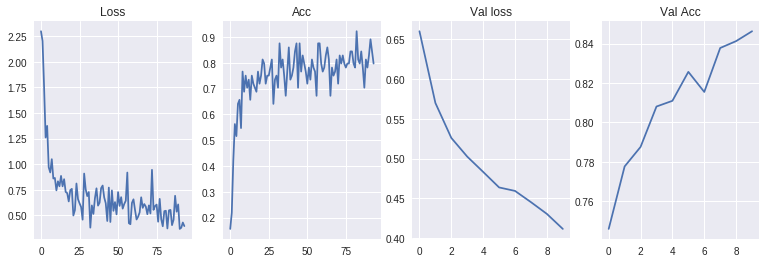

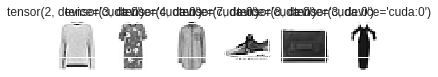

In [0]:
run_experiment(Args(name='fashion_mnist_dropoutBatchnormNet', model='P2Q10DropoutBatchnormNet', dataset='fashion_mnist'))

### Question 11
* Add one extra Conv2D layer, starting from the default Net model


#### Answer

* Output size from a conv layer is:
 * $O = \frac{W - K + 2P}{S} + 1$
 * $W=input \ height/width $
 * $K=filter \ size $
 * $P=padding $
 * $S=stride $
* In our case for the first layer:
 *  $W=28, K=5, P=0, S=1 $
 * $O = \frac{28 - 5 + 2(0)}{1} + 1 = 24$
* After the `max_pool2D`:
 *  $W=24, K=2, P=0, S=2 $
 * $O = \frac{24 - 2 + 2(0)}{2} + 1 = 12$
* Second conv layer output: $8$
* Second `max_pool2D` output: $4$
* To get an output with the same size as input add this much zero padding:
 * $P=\frac{K-1}{2}$
* Changes to original code:
 * Every conv layers has been zero padded to not change the output dimensions of the input
 * Added the third conv layer with $64$ kernels 
 * Changed the input to the first fc layer to $7*7*64 = 3136$
 
Adding an extra layer to the network improved accuracy to $88.67\%$. As stated before in the double channels net, the original network is probably underfitting the data. Adding another layer improved the accuracy even more than just doubling the number of output channels from the first network. Also in this network, I made sure that the conv layers perserve input sizes. According to the Stanford CS231 course notes, generally the conv layers are zero padded to perserve input sizes.

* **ExtraConvNet**
![alt text](https://github.com/AlexDaIii/fashion_mnist_cs482/blob/master/Programming/p02_deep_learning_scs/11_fashion_mnist_extraconv_net.png?raw=true"dropoutbatchnormNet")

#### Code

##### ExtraConvNet

Training:   0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 1 validation test results - Average val_loss: 0.5773, val_acc: 7818.0/10000 (78.18%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 2 validation test results - Average val_loss: 0.4856, val_acc: 8138.0/10000 (81.38%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 3 validation test results - Average val_loss: 0.4334, val_acc: 8406.0/10000 (84.06%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 4 validation test results - Average val_loss: 0.3891, val_acc: 8573.0/10000 (85.73%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 5 validation test results - Average val_loss: 0.3656, val_acc: 8645.0/10000 (86.45%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 6 validation test results - Average val_loss: 0.3471, val_acc: 8718.0/10000 (87.18%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 7 validation test results - Average val_loss: 0.3332, val_acc: 8787.0/10000 (87.87%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 8 validation test results - Average val_loss: 0.3375, val_acc: 8759.0/10000 (87.59%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 9 validation test results - Average val_loss: 0.3086, val_acc: 8871.0/10000 (88.71%)


Validation: 100%|██████████| 10/10 [00:01<00:00,  6.10it/s]



Epoch: 10 validation test results - Average val_loss: 0.3094, val_acc: 8867.0/10000 (88.67%)


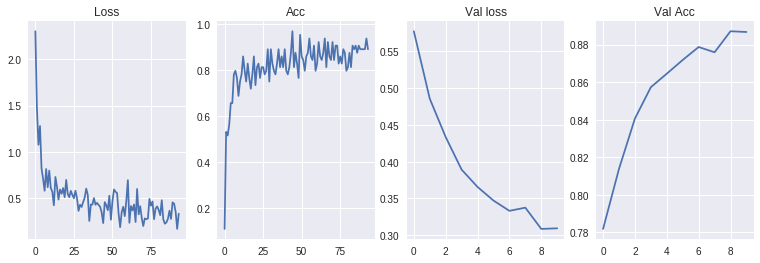

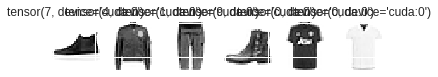

In [0]:
run_experiment(Args(name='fashion_mnist_extraconvNet', model='P2Q11ExtraConvNet', dataset='fashion_mnist'))

### Question 12
* Remove a layer of your choice, starting from the default Net model
    - In addition to the standard questions, what did you choose and why?

#### Answer

I choose to remove the Max Pooling layer of the network. Max Pool acts like a regularizer by reducing the amount of parameters in the netowrk. I choose it because the output image is a $4*4*1$ image after the last max pooling layer and I thought that too much information was being lost with the last max pool. Also I didn't think such a small and simple network needed any more regularization. By removing the last max pool, accuracy increased to $88.20\%$. 

* **RemoveConvNet**
![alt text](https://github.com/AlexDaIii/fashion_mnist_cs482/blob/master/Programming/p02_deep_learning_scs/12_fashion_mnist_removelayer_net.png?raw=true"dropoutbatchnormNet")

#### Code

##### RemoveLayerNet

Training:   0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 1 validation test results - Average val_loss: 0.5859, val_acc: 7728.0/10000 (77.28%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 2 validation test results - Average val_loss: 0.4988, val_acc: 8085.0/10000 (80.85%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 3 validation test results - Average val_loss: 0.4483, val_acc: 8304.0/10000 (83.04%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 4 validation test results - Average val_loss: 0.4226, val_acc: 8446.0/10000 (84.46%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 5 validation test results - Average val_loss: 0.3887, val_acc: 8572.0/10000 (85.72%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 6 validation test results - Average val_loss: 0.3717, val_acc: 8648.0/10000 (86.48%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 7 validation test results - Average val_loss: 0.3578, val_acc: 8693.0/10000 (86.93%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 8 validation test results - Average val_loss: 0.3406, val_acc: 8753.0/10000 (87.53%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 9 validation test results - Average val_loss: 0.3494, val_acc: 8744.0/10000 (87.44%)


Validation: 100%|██████████| 10/10 [00:01<00:00,  6.33it/s]



Epoch: 10 validation test results - Average val_loss: 0.3257, val_acc: 8820.0/10000 (88.20%)


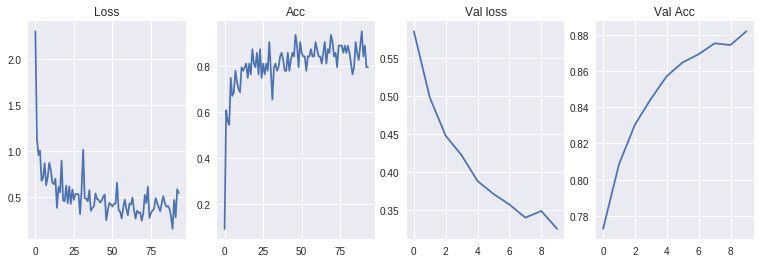

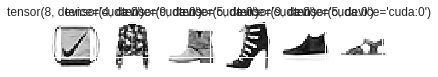

In [0]:
run_experiment(Args(name='fashion_mnist_removeLayerNet', model='P2Q12RemoveLayerNet', dataset='fashion_mnist'))

## Become the ultimate Fashion-MNIST model (25 points)


### Question 13
* Create the best model you can on Fashion-MNIST based on your experience from the previous questions.
    - A minimum of 92% validation accuracy is required for full credit.
    - Make sure to save your best model checkpoints or you'll be out of luck.
    - Feel free to use outside literature
    - Please write your own code
    - Also answer the following questions


#### Answer

I choose to use the third version of Ultimate Net, UltimateNet03, going forward because it got marginally better than the other Ultimate Nets. In UltimateNet ($92.08\%$) and UltimateNet00 ($92.10\%$), I forgot to add a ReLU after the third convolution. Somehow it still worked just as well as UltimateNet02 ($92.08\%$) which included the ReLU. In UltimateNet00, which was the original UltimateNet, there was no dropout which only marginally improved accuracy.

UltimateNet03 ($92.44\%$) was based off of the AlexNet architecture and was as close as possible to that as possible. 

UltimateNet03 changes:

*  Added 3 more $3*3$ conv layers for a total of 5 conv layers
*  Increased output channels of all 5 conv layers to the amount in AlexNet
*  All conv layers perserve input size
*  Added batch norm before every ReLU except the last conv layer
*  Ran for 15 epochs
*  Used Adam optimizer with default settings

Some differences with AlexNet
*  The first $11*11$ kernel had to be decreased down beacause these were $8*8$ images
*  The last max pool is kinda wierd because its stride is not the kernel size so its mixing some information between pixels while downsampling. Didn't know Pytorch floors the amount of times slides the max pooling filter.
*   Batch norm now exists and before batch norm it was worse than the other UltimateNets
*   Forgot there a second fully connected layer before the output
*  Dropout on the first 2 conv layers which was a relic from copying UltimateNet

**Analysis** <br>
1. What does each change do mathematically?
  * Zero Padding - Adding a zero padding of 2 to an $8*8$ image is sort of like taking the $8*8$ matrix and adding 2 rows and 2 columns of all 0's on each side of the matrix. 
  * Increasing Channels - Each layer performs more convolutions each time.
  * Changing Kernel Size - Decreasing a kernel size from $5*5$ to $3*3$ is decreasing the number of pixels convolved during each convolution.
  * Increasing Layers - Increases the number of groups of matricies that the image is convolved with.
  * Batch Norm - Takes the data and compute the mean and variance of all the examples a single neuron sees and normalizes the outputs of the neuron by subtracting the mean and dividing by the variance.
  * Dropout - Takes out some of the nodes in that layer during during training with probability $(1-p)$.
  * Epochs - Doesn't change any equations in the model, just determines how many times the model will be fed the training data.
2. What does each change do algorithmically?
  * Zero Padding - Adds a border of 0's around the image so when the kernel performs a convolution the output size is equal to the input size (width and height). 
  * Increasing Channels - Increases the number of kernels that are convolved with the image. 
  * Changing Kernel Size - Changes the filter size and amount of pixels a kernel will see at one time.
  * Increasing Layers - Increases the amount of successive groups of filters an image will go through
  * Batch Norm - Takes the data and normalizes it with standard mean and variance
  * Dropout - Takes out some of the nodes in that layer during during training with probability $(1-p)$
  * Epochs - Increase the number of forward passes and backward passes (gradient updates) that are performed with the whole entire training data set.
3. How and why does the loss, accuracy, validation loss, and validation accuracy change?
  *   Loss and accuracy increased with UltimateNet 03 beacuse the model was better able to fit the data than the simplier model. I know with a shallower net like UltimateNet 00 with 20 iterations, it can get 96% training accuracy at 20 epochs (and overfit and go from 92% to low 91% validation accuracy). The loss and accuracy for the training set looks like it can keep going down and up, respectively, which probably means it has not converged. However, from experience with even simplier UltimateNets, training for more iterations generally lead to ovrefitting. 
  * Validation accuracy increased and loss decreased with the UltimateNets. However, I had to watch how many epochs I trained because I decided to add dropout with only a p=0.2 on a few layers. After the $11^{th}$ epoch I saw model start to decrease in accuracy; however, it managed to get into a minima during the last epoch and get the $92\%$ accuracy.  
4. How and why does the training time change? (if at all)
  *   Training time increased and the number of iterations per second decreased from about $32 its/sec$ to $18 its/sec$. This is beacuse the computer has to perform a lot more matrix multiplication and batch norm computations every forward pass and more time updating the many more weights and biases. Also I increased the number of training iterations.
5. Explain why you would want to apply such a change to your model.
  * Zero Padding - I saw that apparently most CNNs (including AlexNet) have conv layers perserve the input and output size
  * Increasing Channels - Increasing the number of channels increases the number of parameters. Since increasing it before seemed to improve accuracy and training and validation accuracy were pretty low, the simpler model was underfitting.
  * Changing Kernel Size - The second layer of UltimateNet03 is a $3*3$ convolution these images were only $8*8$. I just wanted filter that could get finer details from this image because the image was so small and I already had a $5*5$ filter before.
  * Increasing Layers - I saw before that increasing the number of layers before, helped increase the accuracy. In UltimateNet03, the only reason it has so many layers was because that was how many layers AlexNet had. In the other UltimateNets it was because adding the third layer and increasing the number of input channels before increased validation accuracy.
  * Batch Norm - Originally with UltimateNet00, before adding batch norm, it was only getting $90\%$ accuracy. Adding batch norm helped speed up the optimization and allowed it to eventually get the above $92\%$ accuracy. On UltimateNet03 it would not get above $91\%$ without batch norm, probably because it had to search through many many more dimensions. However, With batchnorm, UltimateNet03 marginally beat the other UltimateNets. 
  * Dropout - Originally with UltimateNet00, after adding batch norm, it was getting to $92\%$ then overfitting. So with UltimateNet, I added the Dropout and it allowed me to train for the full 15 epochs. $p=0.2$ because I read that generally you start from a lower $p$ such as $0.2$ before increasing it to $0.5%$. Also I thought that the regularization from dropout should help with batch norm's increased optimization (even though evidence from a few pages above shows this is not always the case). In the end since UltimateNet00 and UltimateNet got pretty much the same accuracy, it was probably not necessary. With UltimateNet03, dropout was just a relic from copying over the original code from UltimateNet01. 
  * Epochs - With UltimateNet00, I saw that it would underfit at 10 epochs so I increased the number of epochs to 20. Since that overfit, I decreased it down to 15 and saw that it would get $92\%$ accuracy at around epoch 11-13. So I set the number of epochs to 12. With UltimateNet, I added Dropout and knew it needed to train a little longer so I tried 15 epochs and got $92\%$ accuracy. With UltimateNet03, it was trained for the same 15 epochs as UltimateNet and it got the $92\%$ accuracy.



* **UltimateNet03** - The one used for Questions 14, 15
![alt text](https://github.com/AlexDaIii/fashion_mnist_cs482/blob/master/Programming/p02_deep_learning_scs/13_fashion_mnist_ultimate_net_03.png?raw=true "UltimateNet03")

Other slightly worse but simplier UltimateNets:
* **UltimateNet00**
![alt text](https://github.com/AlexDaIii/fashion_mnist_cs482/blob/master/Programming/p02_deep_learning_scs/13_fashion_mnist_ultimate_net_00.png?raw=true "UltimateNet00")
* **UltimateNet** (Same as UltimateNet00 but with Dropout)
![alt text](https://github.com/AlexDaIii/fashion_mnist_cs482/blob/master/Programming/p02_deep_learning_scs/13_fashion_mnist_ultimate_net_01.png?raw=true "UltimateNet")
* **UltimateNet02** (Same as UltimateNet but with a ReLU on final conv)
![alt text](https://github.com/AlexDaIii/fashion_mnist_cs482/blob/master/Programming/p02_deep_learning_scs/13_fashion_mnist_ultimate_net_02.png?raw=true "UltimateNet02")

#### Code

##### UltimateNet 0
Note: This was from my another ipython notebook used for testing ultimatenets. The model name needs to be changed to 'UltimateNet00' in this notebook. Also it will not save the model in with this notebook. <br>
Model name: 03_ultimate_net00_92-10.pt

In [0]:
run_experiment(Args(name='fashion_mnist_ultimateNet', model='P2Q13UltimateNet', optimizer='adam', lr=0.001, epochs=12, dataset='fashion_mnist'))

##### UltimateNet
Note: I forgot to put a ReLU on the last conv2d layer. This model WILL be saved.<br>
Model name: 04_ultimate_net_92-08.pt 

Training:   0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 1 validation test results - Average val_loss: 0.3760, val_acc: 8560.0/10000 (85.60%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 2 validation test results - Average val_loss: 0.3152, val_acc: 8850.0/10000 (88.50%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 3 validation test results - Average val_loss: 0.2912, val_acc: 8973.0/10000 (89.73%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 4 validation test results - Average val_loss: 0.2576, val_acc: 9053.0/10000 (90.53%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 5 validation test results - Average val_loss: 0.2515, val_acc: 9086.0/10000 (90.86%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 6 validation test results - Average val_loss: 0.2532, val_acc: 9044.0/10000 (90.44%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 7 validation test results - Average val_loss: 0.2407, val_acc: 9131.0/10000 (91.31%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 8 validation test results - Average val_loss: 0.2446, val_acc: 9105.0/10000 (91.05%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 9 validation test results - Average val_loss: 0.2389, val_acc: 9167.0/10000 (91.67%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 10 validation test results - Average val_loss: 0.2391, val_acc: 9113.0/10000 (91.13%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 11 validation test results - Average val_loss: 0.2227, val_acc: 9176.0/10000 (91.76%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 12 validation test results - Average val_loss: 0.2356, val_acc: 9205.0/10000 (92.05%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 13 validation test results - Average val_loss: 0.2260, val_acc: 9218.0/10000 (92.18%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 14 validation test results - Average val_loss: 0.2452, val_acc: 9201.0/10000 (92.01%)


Validation: 100%|██████████| 10/10 [00:02<00:00,  5.08it/s]



Epoch: 15 validation test results - Average val_loss: 0.2309, val_acc: 9208.0/10000 (92.08%)
Saving Model to:  /content/drive/My Drive/cs482/data/10-03-17-47_fashion_mnist_fashion_mnist_ultimateNetultimate_net.pt
Congratulations, you beat the Question 13 minimum of 92with (0.92%) validation accuracy!


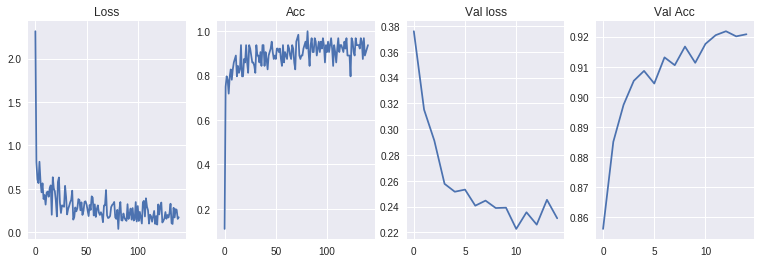

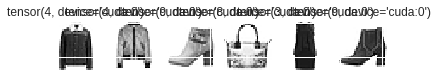

In [0]:
run_experiment(Args(name='fashion_mnist_ultimateNet', model='P2Q13UltimateNet', optimizer='adam', lr=0.001, epochs=15, dataset='fashion_mnist'))

##### Ultimate Net 2
Note: Fixes the forgotten ReLU on last conv2d layer. This model will be not saved if run with this notebook <br>
Model name: 05_ultimate_net_92-08.pt 

In [0]:
run_experiment(Args(name='fashion_mnist_ultimateNet', model='UltimateNet02', optimizer='adam', lr=0.001, epochs=20, dataset='fashion_mnist'))

##### Ultimate Net 3 - As close to AlexNet as possible
Note: This model will be not saved if run with this notebook <br>
Model name: 06_ultimate_net03_92-44.pt

In [0]:
run_experiment(Args(name='fashion_mnist_ultimateNet', model='UltimateNet03', optimizer='adam', lr=0.001, epochs=15, dataset='fashion_mnist'))

## Fine tuning between datasets (3 points each)


### Question 14
* Evaluate your "ultimate Fashion-MNIST model" by loading the trained weights and
    running on MNIST without changing the Fashion-MNIST weights at all.
    
Using: `06_ultimate_net03_92-44.pt` from UltimateNet 03 beacuse it had the highest validation accuracy


#### Answer

After evaluating it on MNIST, the UltimateNet03 model trained on Fashion MNIST could not predict any of the MNIST digits. It was randommly guessing what digit it was.

* **Evaluation** - with UltimateNet03
![alt text](https://github.com/AlexDaIii/fashion_mnist_cs482/blob/master/Programming/p02_deep_learning_scs/14_ultimate_net_mnist.png?raw=true "UltimateNet03")

#### Code

##### UltimateNet MNIST Predictions

In [0]:
# Model name: 06_ultimate_net03_92-44.pt
model_path = '/content/drive/My Drive/cs482/data/06_ultimate_net03_92-44.pt'
the_model = UltimateNet03()
the_model.load_state_dict(torch.load(model_path))
print('Accuracy for Fashion MNIST')
run_eval(Args(dataset='fashion_mnist'), the_model)
print('Accuracy for MNIST')
run_eval(Args(dataset='mnist'), the_model)

### Question 15 
* Reduce your SGD learning rate by 20x, and train MNIST on your ultimate Fashion-MNIST model
     - Compare this to your original MNIST training run and the previous question

#### Answer

After training on the MNIST, UltimateNet03 got $97.01\%$ accuracy. This is worse than the original simple MNIST classifier, but much better than just guessing, in Question 14. The model doesn't seem to be overfitting since traiing accuracy is pretty low, while testing accuracy is still pretty high. It proabbly has to do with the fact that we have decreased the learning rate so much that it hasn't fully converged yet. However, even with such a low learning rate, it was still able do get pretty well on MNIST, which shows that MNIST is a really much easier than Fashion MNIST.

* **Evaluation** - with UltimateNet03
![alt text](https://github.com/AlexDaIii/fashion_mnist_cs482/blob/master/Programming/p02_deep_learning_scs/15_mnist_ultimate_net_03.png?raw=true "UltimateNet03")

#### Code

##### UltimateNet MNIST Train

Training:   0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 1 validation test results - Average val_loss: 2.0972, val_acc: 5191.0/10000 (51.91%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 2 validation test results - Average val_loss: 1.2303, val_acc: 7992.0/10000 (79.92%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 3 validation test results - Average val_loss: 0.5453, val_acc: 9112.0/10000 (91.12%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 4 validation test results - Average val_loss: 0.2857, val_acc: 9468.0/10000 (94.68%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 5 validation test results - Average val_loss: 0.1805, val_acc: 9592.0/10000 (95.92%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 6 validation test results - Average val_loss: 0.1361, val_acc: 9657.0/10000 (96.57%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 7 validation test results - Average val_loss: 0.1087, val_acc: 9706.0/10000 (97.06%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 8 validation test results - Average val_loss: 0.0926, val_acc: 9747.0/10000 (97.47%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 9 validation test results - Average val_loss: 0.0815, val_acc: 9767.0/10000 (97.67%)


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.54it/s]



Epoch: 10 validation test results - Average val_loss: 0.0732, val_acc: 9791.0/10000 (97.91%)


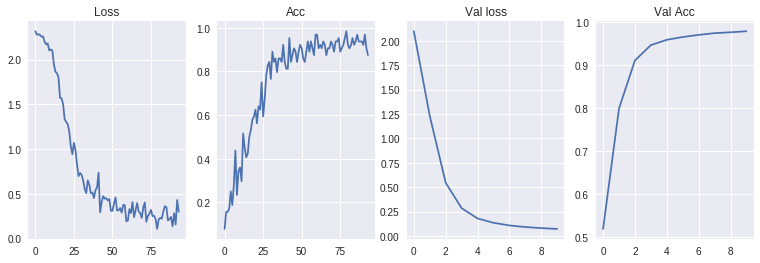

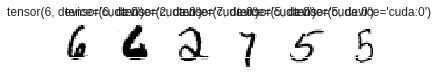

In [0]:
run_experiment(Args(name='mnist_ultimateNet03', model='UltimateNet03', lr=5e-4))

# Check How Much GPU I Have

## Quick check if running with a GPU 

In [0]:
torch.cuda.is_available()

True

## Print how much memory you have & are using
From [here](https://stackoverflow.com/questions/48750199/google-colaboratory-misleading-information-about-its-gpu-only-5-ram-available)

In [0]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]

In [0]:
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 11.1 GB  | Proc size: 1.7 GB
GPU RAM Free: 10857MB | Used: 582MB | Util   5% | Total 11439MB


# Check Output Size

In [0]:
def output_size(w, k, p, s, name=None):
  o = ((w-k+2*p) / s) + 1
  if name is None:
    name = ""
  print("Output size for layer", name, "is:", o)
  return o

In [0]:
x = output_size(w=28, k=5, p=2, s=1, name="conv1")
x = output_size(w=x, k=2, p=0, s=2, name="maxPool1")
x = output_size(w=x, k=3, p=1, s=1, name="conv2")
x = output_size(w=x, k=2, p=0, s=2, name="maxPool2")
x = output_size(w=x, k=3, p=1, s=1, name="conv3")
x = output_size(w=x, k=3, p=1, s=1, name="conv4")
x = output_size(w=x, k=3, p=1, s=1, name="conv5")
x = output_size(w=x, k=3, p=0, s=2, name="maxPool3")